# Multi-step Look-ahead Algorithms for Bayesian Optimization

## Problem Motivation
We're focused on solving problems of the form 
$$
x^* = \arg\max_{x \in \mathcal{X}} f(x)
$$
where $f$ is a black-box typically subject to:
<ul>
    <li>evaluation is <span style="color: red">expensive</span></li>
    <li>observations may be <span style="color: red">noisy</span></li>
    <li>may only observe the function value <span style="color: red">(no gradients)</span></li>
</ul>

In order to perform Bayesian optimization, we need two critical components:
1. a Bayesian statistical model for modeling the objective
2. a way to construct an acquisition function for deciding the next query location.

Since the word algorithm is in this talk, let's describe a 7-step process governing the high-level details for achieving Vanilla Bayesian Optimization.
1. Gather initial samples
2. Initialize Bayesian statistical model
3. Construct an acquisition function $\alpha$
4. Optimize the acquisition function $\nabla\alpha$
5. Sample $f$ at $x^* = \arg\max_x\nabla\alpha$ and update model
6. Go to step 3 and repeat ad infinitum or until budget is exhausted
7. Propose final recommendation

Shortly, we will begin to explore non-standard flavors of Bayesian Optimization, namely Non-myopic Bayesian Optimization, i.e. adding some sprinkles to our vanilla.
<div style="text-align: center">
    <img src="img/vanilla_sprinkles.jpeg" alt="Vanilla Ice Cream with Sprinkles" width=200 />
</div>

## Let's Play with a 1D Toy Problem Quickly
TODOS:
- Setup toy problem for Bayesian optimization in 1D using rollout framework and animate plots
- Discuss limitations and the utility of being non-myopic. Reference Eric and Xubo's work here

In [1]:
using Plots
include("rollout.jl")
include("testfns.jl")

TestGramacyLee (generic function with 1 method)

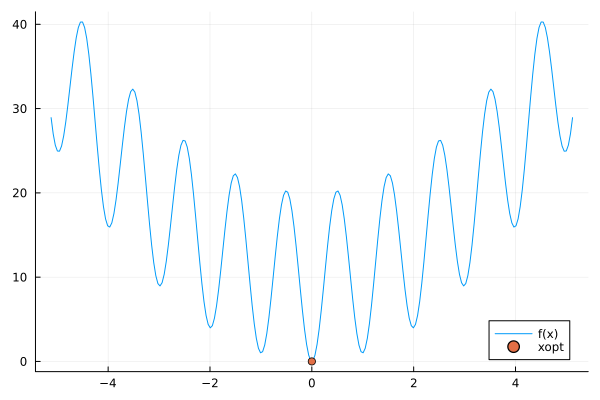

In [2]:
# Setup toy problem test function and display curve
testfn = TestRastrigin(1)
lbs, ubs = testfn.bounds[:,1], testfn.bounds[:,2]
domain = lbs[1]:.01:ubs[1]

tplot(testfn)

In [3]:
# Global parameters for main loop
HORIZON = 0
MC_SAMPLES = 150

# Setup low discrepancy random number stream
lds_rns = gen_low_discrepancy_sequence(MC_SAMPLES, testfn.dim, HORIZON+1);
rns = randn(MC_SAMPLES, testfn.dim+1, HORIZON+1);

### 1. Gathering the Intial Samples 

In [4]:
# Gather initial samples/experimental data
X = [-3.7, 2.1]
X = reshape(X, 1, length(X));

### 2. Initialize Bayesian Statistical Model

In [129]:
θ = [1.]
ψ = kernel_matern52(θ)
sur = fit_surrogate(ψ, X, testfn.f)
θ, sur = optimize_hypers(ψ.θ, kernel_matern52, X, testfn.f)
domain = filter(x -> !(x in sur.X), domain);

(s, constraint, xprev): ([8.431634064942044e-5], false, [1.0])
x: [1.0000843163406494]
(s, constraint, xprev): ([1.0], true, [1.0000843163406494])
x: [2.0000843163406494]
(s, constraint, xprev): ([2.0], true, [2.0000843163406494])
x: [4.000084316340649]
(s, constraint, xprev): ([4.0], true, [4.000084316340649])
x: [8.000084316340649]
(s, constraint, xprev): ([1.6576666809516072], false, [8.000084316340649])
x: [9.657750997292256]
(s, constraint, xprev): ([1.8856869572775046], false, [9.657750997292256])
x: [11.543437954569761]
(s, constraint, xprev): ([1.2723124028464818], false, [11.543437954569761])
x: [12.815750357416242]
(s, constraint, xprev): ([0.6264180530774633], false, [12.815750357416242])
x: [13.442168410493705]
(s, constraint, xprev): ([0.14432471872887037], false, [13.442168410493705])
x: [13.586493129222577]
(s, constraint, xprev): ([0.01154573770325605], false, [13.586493129222577])
x: [13.598038866925833]


### 3. Construct an Acquisition Function
$$
EI(x) = (\mu(x) - f^+ - \xi)\Phi\left( \frac{\mu(x) - f^+ - \xi}{\sigma(x)} \right) +
        \sigma(x)\phi\left(\frac{\mu(x) - f^+ - \xi}{\sigma(x)}\right)
$$

where $\phi$ is the standard normal probability density function.

In [130]:
function splot(s::RBFsurrogate; ymean=1e-8, append=false)
    # Could this be cleaner using macros?
    if append
        plot!(
            domain,
            [s([x]).μ + ymean for x in domain],
            ribbons=[s([x]).σ for x in domain],
            label="μ±σ"
        )
    else
        plot(
            domain,
            [s([x]).μ + ymean for x in domain],
            ribbons=[s([x]).σ for x in domain],
            label="μ±σ"
        )
    end
    scatter!(s.X', s.y .+ ymean, label="History")
    plot!(
        domain,
        [s([x]).EI for x in domain],
        label="α(x)",
        legend=:outertopleft
    )
end

splot (generic function with 1 method)

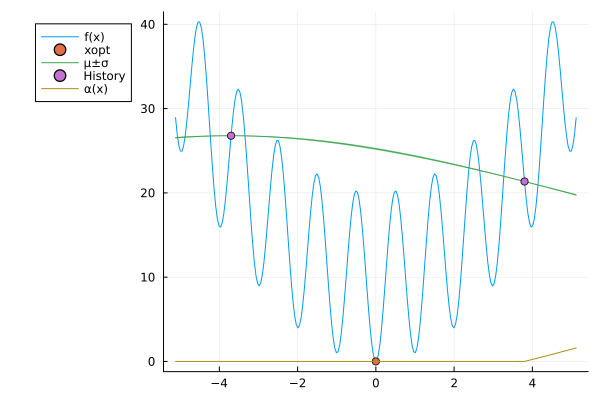

In [131]:
tplot(testfn)
splot(sur, append=true)

### 4. Optimize the Acquisition Function

In [8]:
h, BATCH_SIZE = 1e-2, 60 # Enforce interior point constraint
batch = range(lbs[1]+h, ubs[1]-h, length=BATCH_SIZE)
maxis = []

for x0 in batch
    push!(maxis, ei_solve(sur, lbs, ubs, [x0])[2])
end

maximizer, fmaxi = findmax([Optim.minimizer(r) for r in maxis])

([5.12], 45)

### 5. Sample $f$ at $x^* = \arg\max_x\nabla\alpha$ and update model

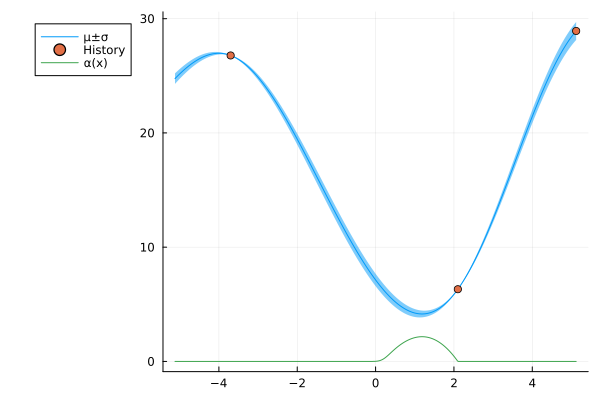

In [9]:
usur = update_surrogate(sur, maximizer, testfn.f);
splot(usur; append=false)

### 6. Let's Make This Iterative

In [320]:
include("rollout.jl")
# Defines the number of iterations
BUDGET = 0
BATCH_SIZE = 200

# Setup black-box objective
testfn = TestRastrigin(1)
lbs, ubs = testfn.bounds[:,1], testfn.bounds[:,2]
domain = lbs[1]:.01:ubs[1]

# Gather initial samples
X = [-3.7, 0., 3.8] #, -4.1, 3.1, -3.1, 2.6, 0.7, -1.2]
X = reshape(X, 1, length(X));

# Initialize the surrogate with hyperparameters learning via
# maximum likelihood estimation
θ = [1.]
# ψ = kernel_matern52(θ)
ψ = kernel_SE(θ)
y = [testfn.f(X[:,j]) for j in 1:size(X, 2)]
ymean = mean(y)
yy = y .- ymean
# sur = fit_surrogate(ψ, X, yy)
θ, sur = optimize_hypers_v(ψ.θ, kernel_matern52, X, yy)
domain = filter(x -> !(x in sur.X), domain);

# Initialize batch of points for multi-start optimization of α(x)
batch = range(lbs[1]+h, ubs[1]-h, length=BATCH_SIZE)

# Iterate until budget is exhausted
for b in 1:BUDGET
    h, maxi_candidates, BATCH_SIZE = 1e-2, [], 15
    
    # Find candidate locations for each input in batch
    for x0 in batch
        push!(maxi_candidates, ei_solve(sur, lbs, ubs, [x0])[2])
    end
    
    # Eval each candidate location
    fmaxi, fmaxi_ndx = findmin([Optim.minimum(r) for r in maxi_candidates])
    maximizer = Optim.minimizer(maxi_candidates[fmaxi_ndx])
    
    yy = vcat(sur.y .+ ymean, testfn.f(maximizer) - ymean)
    ymean = mean(yy)
    yy = yy .- ymean
    sur = update_surrogate(sur, maximizer, yy);
    # θ, sur = optimize_hypers(sur.ψ.θ, kernel_matern52, sur.X, yy .+ ymean)
    
    # θ, sur = optimize_hypers(sur.ψ.θ, kernel_matern52, hcat(sur.X, maximizer), yy .+ ymean)
end
println("Final Hyperparameter Vector: $(sur.ψ.θ)")

Final Hyperparameter Vector: [133.60892347741495, 0.3946084839463374]


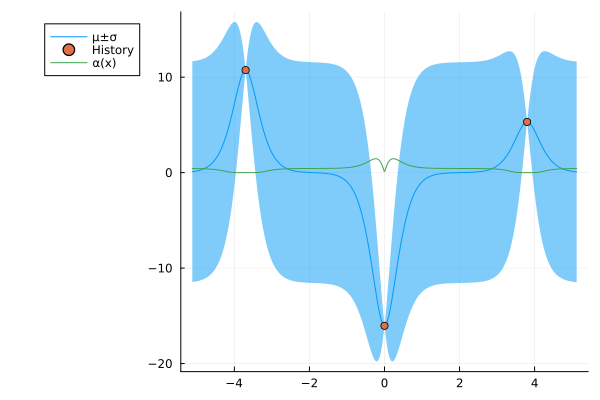

In [321]:
splot(sur, append=false, ymean=0.)

In [322]:
using GaussianProcesses

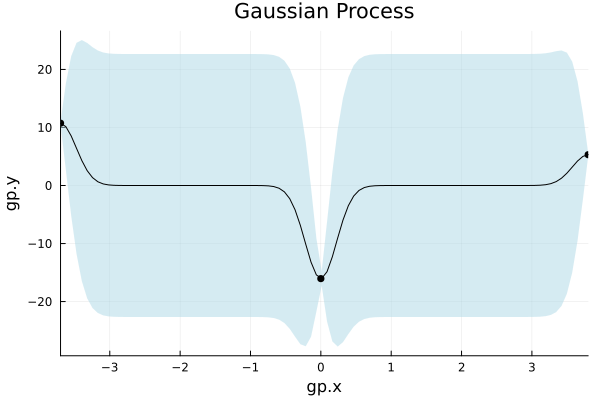

In [323]:
m = MeanZero()
se = SEIso(log(.05)/2., 0.)
# logObsNoise = -Inf
# gp = GP(sur.X, sur.y, m, se, logObsNoise)
gp = GP(sur.X, sur.y, m, se)
optimize!(gp; noise=false)
plot(gp; xlabel="gp.x", ylabel="gp.y", title="Gaussian Process", legend=false, fmt=:png)

In [324]:
GaussianProcesses.get_params(se)

2-element Vector{Float64}:
 -1.4978661367769954
  2.4473904055391893

In [325]:
println(gp.kernel)

Type: SEIso{Float64}, Params: [-1.4978661367769954, 2.4473904055391893]


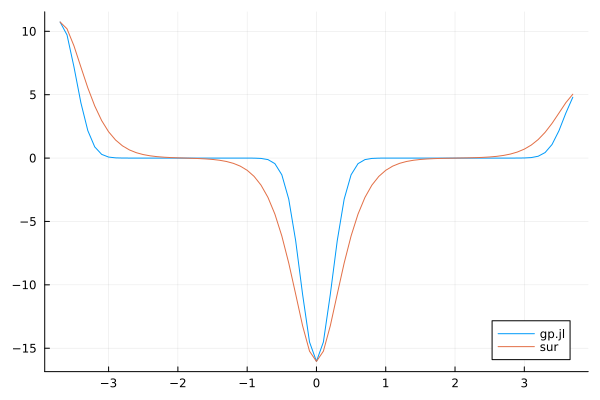

In [331]:
gpμ, gpσ2 = predict_y(gp, new_domain)
surμ, surσ2 = [sur([x]).μ for x in new_domain], [sur([x]).σ for x in new_domain]
# plot(new_domain, norm.(gpμ - surμ))
plot(new_domain, gpμ, label="gp.jl")
plot!(new_domain, surμ, label="sur")

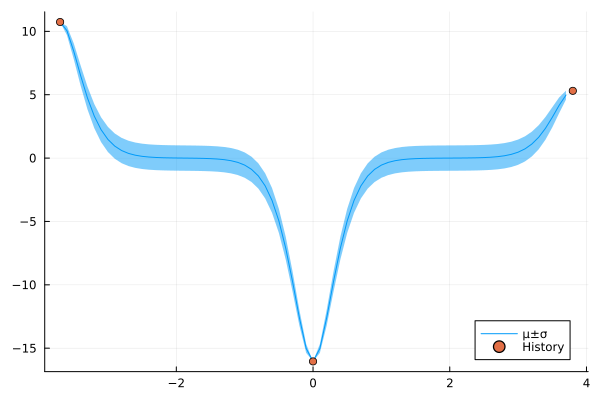

In [253]:
new_domain = -3.7:.1:3.7
plot(
    new_domain,
    [sur([x]).μ for x in new_domain],
    ribbons=[sur([x]).σ for x in new_domain],
    label="μ±σ"
)
scatter!(sur.X', sur.y, label="History")

In [182]:
sur.ψ.θ

1-element Vector{Float64}:
 0.7384239581805705

In [158]:
log(sur.ψ.θ[1])

0.0